# Gait Event Classification using LSTM

This notebook implements a Long Short-Term Memory (LSTM) neural network for classifying gait events using sensor data from IMUs (Inertial Measurement Units).

## Setup and Imports
The following cell imports necessary libraries and sets up the computation device:
- `pandas` and `numpy` for data manipulation
- `torch` for deep learning implementation
- `sklearn` for preprocessing and evaluation metrics

The model will run on MPS (Metal Performance Shaders) if available, otherwise CPU.

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Data Loading and Preprocessing

## Data Loading Function (`load_data_from_files`)
This function loads and combines data from multiple CSV files containing IMU sensor readings:

1. **Input**: Directory path containing CSV files
2. **Process**:
   - Reads each CSV file
   - Extracts metadata from filenames (collection_id, step number, foot side)
   - Combines all data into a single DataFrame
3. **Output**: Combined DataFrame with sensor data and metadata

## Preprocessing Function (`preprocess_data`)
This function prepares the data for model training:

1. **Features**:
   - 6 sensor measurements: gyroscope (x,y,z) and accelerometer (x,y,z)
2. **Processing Steps**:
   - Removes missing values
   - Normalizes features using MinMaxScaler
   - Encodes categorical labels
3. **Output**: 
   - Preprocessed DataFrame
   - Label encoder for converting predictions back to original labels

In [2]:
############################################
# Data Loading and Preprocessing Functions #
############################################

def load_data_from_files(data_dir):
    all_data = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            # Extract metadata from filename
            collection_id, step_info, _ = filename.split('_', 2)
            step_number = ''.join(filter(str.isdigit, step_info))
            foot = 'R' if 'R' in step_info else 'L'
            filepath = os.path.join(data_dir, filename)
            df = pd.read_csv(filepath)
            df['collection_id'] = collection_id
            df['step_number'] = int(step_number)
            df['foot'] = foot
            df['filename'] = filename  # Keep track of the file
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

def preprocess_data(data):
    # Define features and target
    features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
    target = 'phase'

    # Drop rows with missing values
    data = data.dropna(subset=features + [target])

    # Normalize features
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])

    # Encode target labels
    label_encoder = LabelEncoder()
    data[target] = label_encoder.fit_transform(data[target])

    return data, label_encoder

# Custom Dataset Implementation

## `SensorDataset` Class

This custom PyTorch Dataset class handles the sequential nature of our sensor data:

1. **Initialization**:
   - Takes preprocessed data, feature columns, target column, and sequence length
   - Groups data by filename to maintain temporal consistency

2. **Sequence Generation**:
   - Creates sequences of specified length using a sliding window approach
   - Each sequence contains consecutive sensor readings
   - Labels are taken from the last timestep of each sequence

3. **Data Access**:
   - Returns tensor pairs (X, y) where:
     - X: Sequence of sensor readings [sequence_length × num_features]
     - y: Target label for the sequence

In [3]:
#########################################
# Dataset and DataLoader Preparation    #
#########################################

class SensorDataset(Dataset):
    def __init__(self, data, features, target, sequence_length):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []

        grouped = data.groupby('filename')
        for _, group in grouped:
            group = group.reset_index(drop=True)
            group_length = len(group)
            if group_length >= sequence_length:
                # Generate sequences using a sliding window
                for i in range(group_length - sequence_length + 1):
                    seq = group.iloc[i:i+sequence_length]
                    self.sequences.append(seq[self.features].values)
                    # Use the event at the last time point as the label
                    self.labels.append(seq[self.target].values[-1])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X = self.sequences[idx]
        y = self.labels[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# LSTM Model Architecture

## `LSTMClassifier` Class

This class implements a deep LSTM network for sequence classification:

1. **Architecture Components**:
   - Stacked LSTM layers with configurable depth
   - Dropout for regularization
   - Final fully connected layer for classification

2. **Forward Pass**:
   - Processes input sequences through LSTM layers
   - Takes final timestep output for classification
   - Returns logits for each class

3. **Parameters**:
   - `input_dim`: Number of input features
   - `hidden_dim`: Size of LSTM hidden state
   - `num_layers`: Number of stacked LSTM layers
   - `num_classes`: Number of output classes
   - `dropout`: Dropout probability

In [4]:
#########################################
# Model Definition                      #
#########################################

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take output from the last time step
        return out

# Training and Validation Functions

## Training Function (`train_epoch`)
Handles one epoch of model training:

1. **Process**:
   - Sets model to training mode
   - Processes batches of sequences
   - Computes loss and performs backpropagation
   - Updates model parameters

2. **Metrics**:
   - Tracks loss and accuracy
   - Returns epoch-level metrics

## Validation Function (`validate_epoch`)
Evaluates model performance on validation data:

1. **Process**:
   - Sets model to evaluation mode
   - Processes validation batches
   - No gradient computation or parameter updates

2. **Metrics**:
   - Computes loss and accuracy
   - Returns validation metrics

In [5]:
#########################################
# Training and Validation Functions     #
#########################################

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Model Training and Hyperparameter Tuning

This section implements the training loop with hyperparameter search:

1. **Data Preparation**:
   - Loads and preprocesses data
   - Creates dataset splits (train/val/test)

2. **Hyperparameters**: (this is the configuration that was tested to be the best)
   - LSTM layers: 3
   - Batch size: 128
   - Sequence length: 30
   - Hidden dimensions: 128
   - Learning rate: 0.001
   - Optimizer: Adam

3. **Training Process**:
   - Trains for 10 epochs
   - Tracks best model configuration
   - Monitors training and validation metrics

In [8]:
#########################################
# Hyperparameter Tuning Configuration   #
#########################################

data_dir = 'csv_output_phases'  # Replace with your directory
raw_data = load_data_from_files(data_dir)
data, label_encoder = preprocess_data(raw_data)

# Hyperparameters to tune (already tuned)
lstm_layers_options = [3]
batch_size_options = [128]
sequence_length_options = [30]
hidden_dim_options = [128]
learning_rate_options = [0.001]
optimizer_options = ['adam']
# Different splits could be tested, but keep at least one split consistent first:
data_splits = [
    (0.7, 0.15, 0.15),
]

num_epochs = 10
input_dim = len(['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                 'accelerometer_x', 'accelerometer_y', 'accelerometer_z'])
num_classes = len(label_encoder.classes_)

best_val_acc = -1.0
best_config = None
best_model_state = None

for split in data_splits:
    train_ratio, val_ratio, test_ratio = split

    for seq_length in sequence_length_options:
        # Rebuild dataset and splits for each sequence length
        dataset = SensorDataset(data, 
                                features=['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                                          'accelerometer_x', 'accelerometer_y', 'accelerometer_z'],
                                target='phase', 
                                sequence_length=seq_length)

        dataset_size = len(dataset)
        train_size = int(train_ratio * dataset_size)
        val_size = int(val_ratio * dataset_size)
        test_size = dataset_size - train_size - val_size

        # Set seed for reproducibility in splits
        torch.manual_seed(42)
        train_dataset, val_dataset, test_dataset = random_split(
            dataset, [train_size, val_size, test_size])

        for batch_size in batch_size_options:
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

            for lstm_layers in lstm_layers_options:
                for hidden_dim in hidden_dim_options:
                    for lr in learning_rate_options:
                        for opt_name in optimizer_options:
                            
                            # Initialize model
                            model = LSTMClassifier(input_dim, hidden_dim, lstm_layers, num_classes, dropout=0.5).to(device)
                            criterion = nn.CrossEntropyLoss()

                            if opt_name == 'adam':
                                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                            else:
                                optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

                            # Training loop
                            for epoch in range(num_epochs):
                                train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
                                val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
                                print(f'Epoch {epoch+1}/{num_epochs}, '
                                f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                                f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

                            # Check if this is the best so far
                            if val_acc > best_val_acc:
                                best_val_acc = val_acc
                                best_config = {
                                    'train_ratio': train_ratio,
                                    'val_ratio': val_ratio,
                                    'test_ratio': test_ratio,
                                    'sequence_length': seq_length,
                                    'batch_size': batch_size,
                                    'lstm_layers': lstm_layers,
                                    'hidden_dim': hidden_dim,
                                    'learning_rate': lr,
                                    'optimizer': opt_name
                                }
                                best_model_state = model.state_dict()

Epoch 1/10, Train Loss: 0.6795, Train Acc: 0.6786, Val Loss: 0.2715, Val Acc: 0.8942
Epoch 2/10, Train Loss: 0.2745, Train Acc: 0.8939, Val Loss: 0.2572, Val Acc: 0.9011
Epoch 3/10, Train Loss: 0.2665, Train Acc: 0.8972, Val Loss: 0.3000, Val Acc: 0.8915
Epoch 4/10, Train Loss: 0.2581, Train Acc: 0.9003, Val Loss: 0.2495, Val Acc: 0.9031
Epoch 5/10, Train Loss: 0.2510, Train Acc: 0.9018, Val Loss: 0.2393, Val Acc: 0.9056
Epoch 6/10, Train Loss: 0.2469, Train Acc: 0.9031, Val Loss: 0.2380, Val Acc: 0.9056
Epoch 7/10, Train Loss: 0.2429, Train Acc: 0.9036, Val Loss: 0.2354, Val Acc: 0.9056
Epoch 8/10, Train Loss: 0.2410, Train Acc: 0.9043, Val Loss: 0.2345, Val Acc: 0.9067
Epoch 9/10, Train Loss: 0.2367, Train Acc: 0.9049, Val Loss: 0.2309, Val Acc: 0.9078
Epoch 10/10, Train Loss: 0.2360, Train Acc: 0.9056, Val Loss: 0.2266, Val Acc: 0.9093


# Evaluate Best Model on Test Set

This section assesses the performance of the best model configuration on the test dataset.

---

## Steps

1. **Display Best Metrics:**
   - Prints the highest validation accuracy achieved and the corresponding configuration parameters.

2. **Rebuild Dataset and Model:**
   - Extracts the best configuration settings such as sequence length, batch size, LSTM layers, hidden dimensions, learning rate, optimizer type, and dataset split ratios.
   - Creates a `SensorDataset` using the optimal sequence length.
   - Splits the dataset into training, validation, and test sets based on the best ratios.

3. **Initialize DataLoaders:**
   - Sets up DataLoaders for training, validation, and testing with the optimal batch size and shuffling where appropriate.

4. **Recreate and Load the Model:**
   - Instantiates the `LSTMClassifier` with the best hyperparameters.
   - Loads the saved state of the best-performing model.
   - Sets the model to evaluation mode to prepare for testing.

5. **Evaluate on Test Set:**
   - Iterates through the test DataLoader, making predictions with the model.
   - Collects all predictions and true labels.
   - Generates and prints a classification report detailing precision, recall, f1-score, and support for each class.

---

By executing these steps, we validate the model's effectiveness on unseen data, ensuring its ability to generalize beyond the training and validation sets.

In [9]:
#########################################
# Evaluate Best Model on Test Set       #
#########################################

print("Best Validation Accuracy: ", best_val_acc)
print("Best Configuration: ", best_config)

# Rebuild the dataset and model with best config
sequence_length = best_config['sequence_length']
batch_size = best_config['batch_size']
lstm_layers = best_config['lstm_layers']
hidden_dim = best_config['hidden_dim']
lr = best_config['learning_rate']
opt_name = best_config['optimizer']
train_ratio = best_config['train_ratio']
val_ratio = best_config['val_ratio']
test_ratio = best_config['test_ratio']

# Recreate dataset with the best sequence length
best_dataset = SensorDataset(data,
                            features=['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                                      'accelerometer_x', 'accelerometer_y', 'accelerometer_z'],
                            target='phase', 
                            sequence_length=sequence_length)

dataset_size = len(best_dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

torch.manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    best_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Recreate model and load best state
final_model = LSTMClassifier(input_dim, hidden_dim, lstm_layers, num_classes, dropout=0.5).to(device)
final_model.load_state_dict(best_model_state)
final_model.eval()

# Evaluate on test set
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = final_model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

class_names = ['no event', 'heel strike', 'foot flat', 'heel off', 'toe off']
print(classification_report(all_labels, all_preds, target_names=class_names))

Best Validation Accuracy:  0.9093235222868217
Best Configuration:  {'train_ratio': 0.7, 'val_ratio': 0.15, 'test_ratio': 0.15, 'sequence_length': 30, 'batch_size': 128, 'lstm_layers': 3, 'hidden_dim': 128, 'learning_rate': 0.001, 'optimizer': 'adam'}
              precision    recall  f1-score   support

    no event       0.80      0.20      0.32       265
 heel strike       0.00      0.00      0.00        33
   foot flat       0.90      0.93      0.92     22740
    heel off       0.83      0.76      0.79     14536
     toe off       0.95      0.97      0.96     28474

    accuracy                           0.91     66048
   macro avg       0.70      0.57      0.60     66048
weighted avg       0.91      0.91      0.91     66048



/opt/anaconda3/envs/ap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ap/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# After training is complete
model_save_path = 'best_lstm_model_phases.pth'
torch.save(final_model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to best_lstm_model_phases.pth


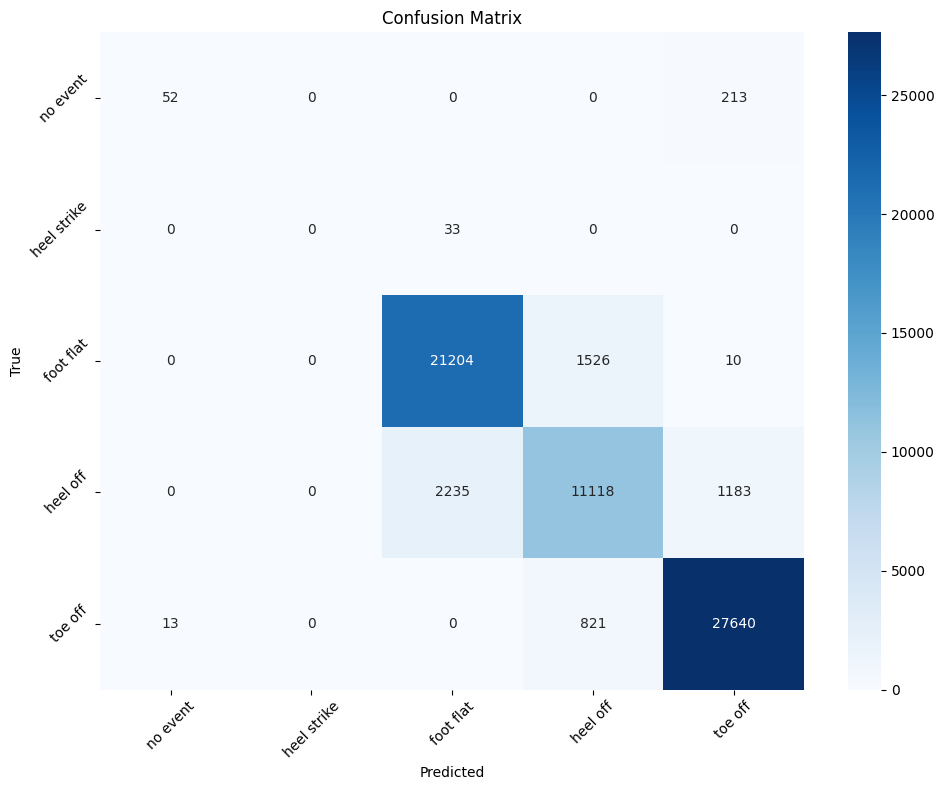

In [11]:
# Add visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# Create and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

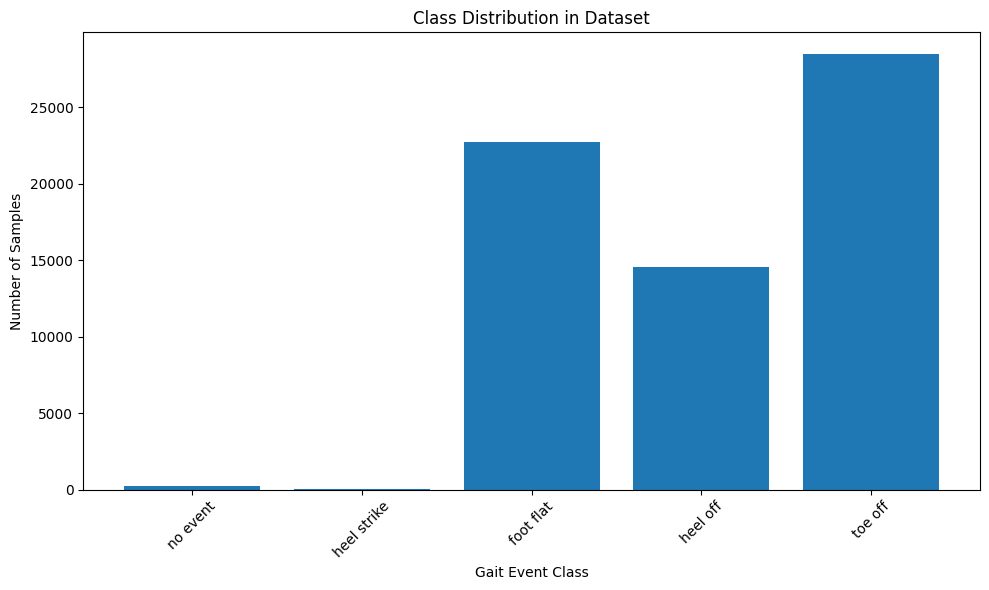

In [12]:
# Plot class distribution
plt.figure(figsize=(10, 6))
class_counts = np.bincount(all_labels)
plt.bar(class_names, class_counts)
plt.title('Class Distribution in Dataset')
plt.xlabel('Gait Event Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

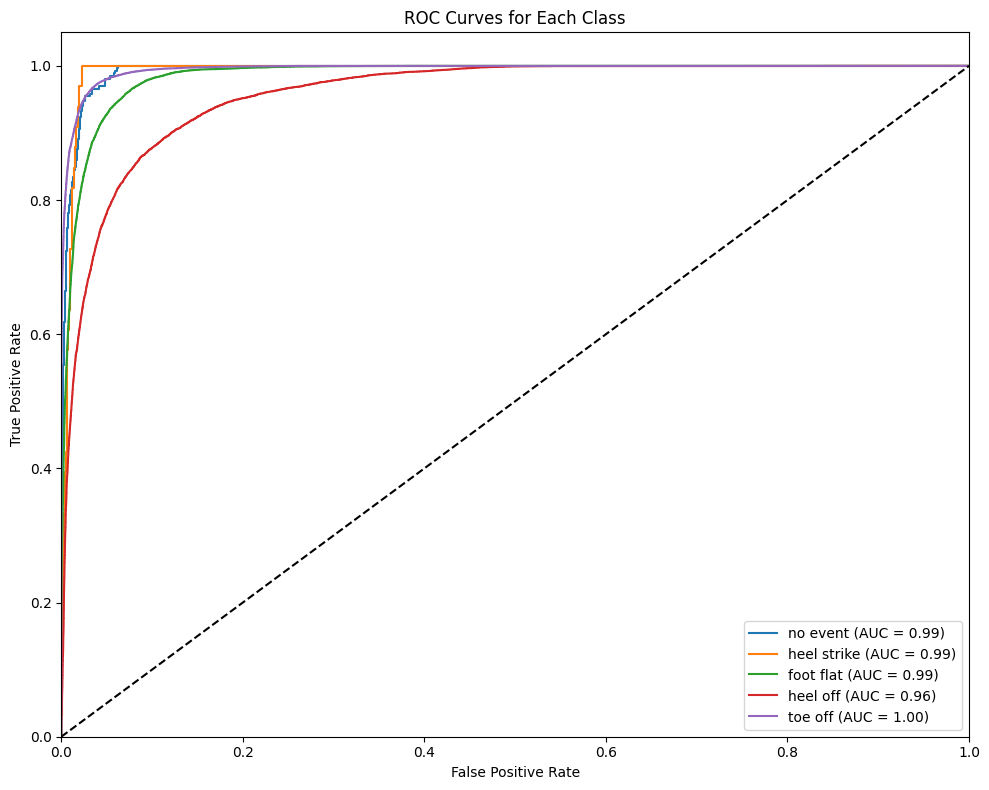

In [13]:
# Get prediction probabilities for ROC curves
all_probs = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = final_model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(np.array(all_labels) == i, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

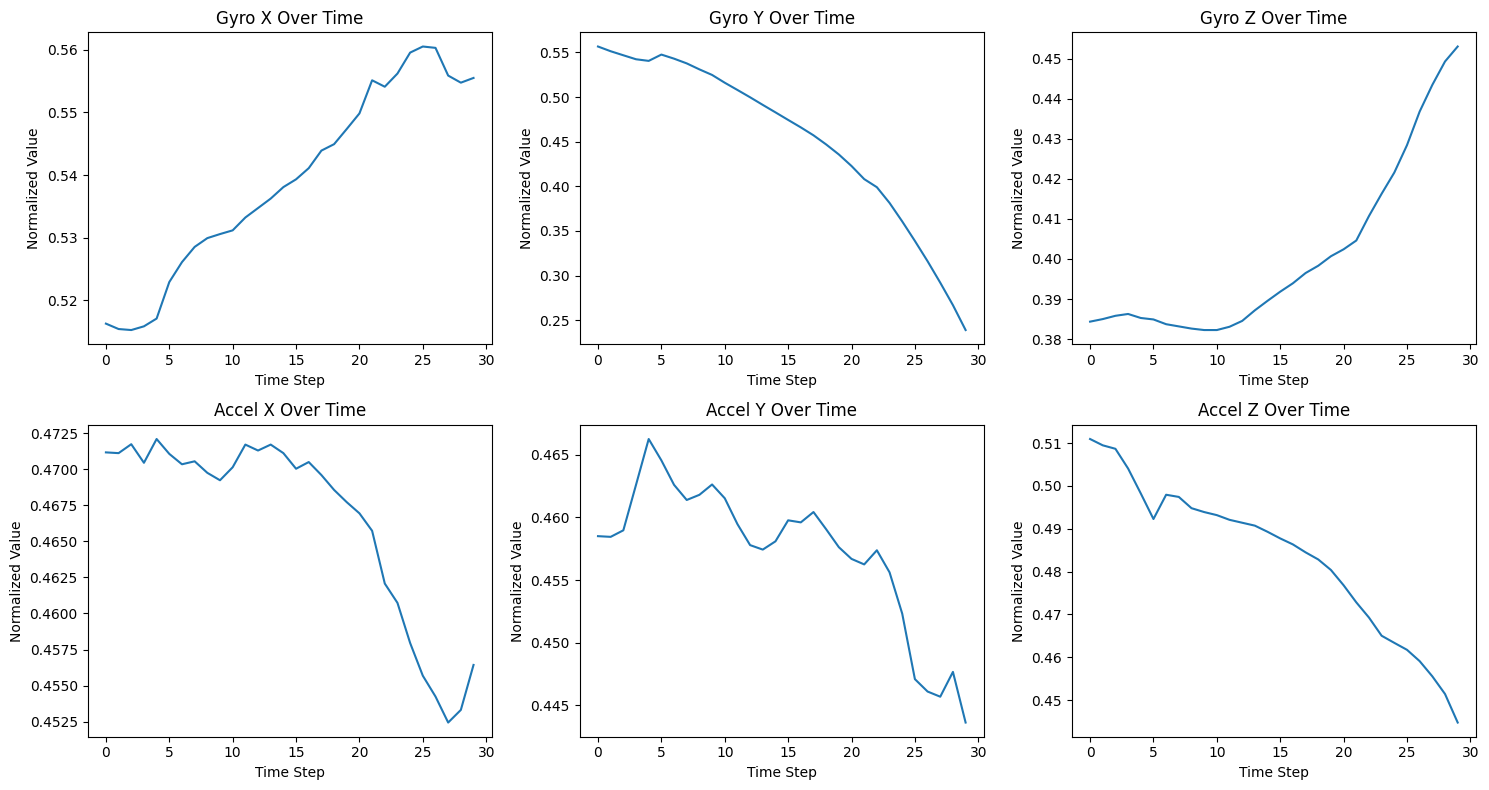

In [14]:
# Get a sample sequence and visualize sensor data
sample_X, sample_y = next(iter(test_loader))
sample_X = sample_X[0].numpy()  # Take first sequence from batch

# Plot sensor data
plt.figure(figsize=(15, 8))
features = ['Gyro X', 'Gyro Y', 'Gyro Z', 'Accel X', 'Accel Y', 'Accel Z']
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(sample_X[:, i])
    plt.title(f'{features[i]} Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
plt.tight_layout()
plt.show()

In [15]:
# Create a summary table
from tabulate import tabulate

summary_data = [
    ['Metric', 'Value'],
    ['Best Validation Accuracy', f'{best_val_acc:.4f}'],
    ['Final Test Accuracy', f'{np.mean(np.array(all_labels) == np.array(all_preds)):.4f}'],
    ['Number of Model Parameters', sum(p.numel() for p in final_model.parameters())],
    ['Training Time (epochs)', num_epochs],
    ['Sequence Length', sequence_length],
    ['Batch Size', batch_size],
    ['LSTM Layers', lstm_layers],
    ['Hidden Dimensions', hidden_dim]
]

print("\nModel Performance Summary:")
print(tabulate(summary_data, headers='firstrow', tablefmt='grid'))


Model Performance Summary:
+----------------------------+-------------+
| Metric                     |       Value |
+============================+=============+
| Best Validation Accuracy   |      0.9093 |
+----------------------------+-------------+
| Final Test Accuracy        |      0.9086 |
+----------------------------+-------------+
| Number of Model Parameters | 334469      |
+----------------------------+-------------+
| Training Time (epochs)     |     10      |
+----------------------------+-------------+
| Sequence Length            |     30      |
+----------------------------+-------------+
| Batch Size                 |    128      |
+----------------------------+-------------+
| LSTM Layers                |      3      |
+----------------------------+-------------+
| Hidden Dimensions          |    128      |
+----------------------------+-------------+
